In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
DATA_DIR = "/root/autodl-tmp/cervical_spine/"
prediction_path = '/root/autodl-tmp/cervical_spine/predictions/axial_detection_effdet_193536_predictions.csv'

# prediction_path = '/root/autodl-tmp/cervical_spine/predictions/predictions-135654-baseline.csv'

In [3]:
columns = ['UID'] + [f'P{i}' for i in range(8)] + ['loss','loss_pos','loss_neg'] + [f'C{i}' for i in range(8)] 
patient_pred_df = pd.read_csv(prediction_path, names=columns)

patient_pred_df

,UID,P0,P1,P2,P3,P4,P5,P6,P7,loss,loss_pos,loss_neg,C0,C1,C2,C3,C4,C5,C6,C7
0,1.2.826.0.1.3680043.10001,0.059850,0.031841,0.030763,0.014647,0.016467,0.022044,0.059850,0.045987,0.047004,0.000000,0.047004,0,0,0,0,0,0,0,0
1,1.2.826.0.1.3680043.10005,0.983275,0.025593,0.176114,0.022742,0.049382,0.081991,0.983275,0.426683,2.404410,0.000000,2.404410,0,0,0,0,0,0,0,0
2,1.2.826.0.1.3680043.10014,0.996666,0.023232,0.020748,0.012816,0.996666,0.991646,0.034294,0.071286,3.612771,0.000000,3.612771,0,0,0,0,0,0,0,0
3,1.2.826.0.1.3680043.10016,0.131940,0.020525,0.100800,0.031782,0.018828,0.046879,0.033397,0.131940,1.510932,2.059061,0.049253,1,0,1,0,0,0,0,0
4,1.2.826.0.1.3680043.10032,0.060200,0.036914,0.026288,0.018631,0.060200,0.030131,0.053698,0.046556,0.050945,0.000000,0.050945,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2007,1.2.826.0.1.3680043.9926,0.999000,0.999000,0.999000,0.017852,0.030503,0.018810,0.010598,0.067950,0.321489,0.001001,1.176126,1,0,1,0,0,0,0,0
2008,1.2.826.0.1.3680043.9940,0.999000,0.015636,0.024689,0.999000,0.999000,0.019737,0.018560,0.011139,0.645433,0.437029,1.395690,1,0,0,0,1,1,0,0
2009,1.2.826.0.1.3680043.9994,0.932973,0.018851,0.018009,0.012359,0.026139,0.022178,0.932973,0.029827,1.553583,0.000000,1.553583,0,0,0,0,0,0,0,0
2010,1.2.826.0.1.3680043.9996,0.405173,0.079041,0.082199,0.013886,0.031234,0.010471,0.405173,0.035053,0.833598,1.102838,0.115624,1,0,1,0,0,0,0,0


In [4]:
# patient_pred_df = pd.read_csv('/root/autodl-tmp/df_patient_pred_7945.csv',header = 0, names=['StudyInstanceUID'] + [f'P{i}' for i in range(8)]).set_index('StudyInstanceUID')
# label_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv')).set_index('StudyInstanceUID')
# # patient_pred_df.rename(columns = {"patient_overall" : "UID"}, inplace = True)

# label_df.rename(columns = {"patient_overall" : "C0"}, inplace = True)
# patient_pred_df = pd.concat((patient_pred_df, label_df), axis=1)
# patient_pred_df = patient_pred_df[~pd.isna(patient_pred_df['P0'])]
# patient_pred_df

In [5]:
def cal_loss(prob, label):
    
    pos_weight = np.array([14, 2, 2, 2, 2, 2, 2, 2])
    neg_weight = np.array([7, 1, 1, 1, 1, 1, 1, 1])
    
    score = pos_weight * label * np.log(prob) + neg_weight * (1 - label) * np.log(1 - prob)
    
    weight_total = pos_weight * label + neg_weight * (1 - label)
    
    return -score.sum() / weight_total.sum()

In [6]:
prob = patient_pred_df[[f'P{i}' for i in range(8)]].values
label = patient_pred_df[[f'C{i}' for i in range(8)]].values

In [7]:
loss = cal_loss(prob, label)
print('baseline:', loss)

baseline: 0.4487373458900019


min loss: 0.42860349214861837


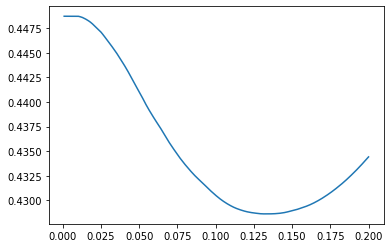

In [8]:
# only clip lower bound
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=clip, a_max=1)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

min loss: 0.4303821987749776


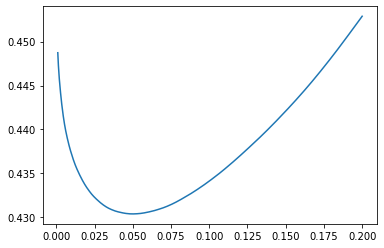

In [9]:
# clip upper
losses = []

clips = np.linspace(0.001, 0.2, 1000)
for clip in clips:
    new_prob = np.clip(prob, a_min=0, a_max=1-clip)
    loss= cal_loss(new_prob, label)
    
    losses.append(loss)
print('min loss:', np.min(losses))
plt.plot(clips, losses)

In [10]:
# clip both
losses = []

min_clips = np.linspace(0.001, 0.2, 200)
max_clips = np.linspace(0.001, 0.2, 200)

for min_clip in tqdm(min_clips):
    
    for max_clip in max_clips:
        new_prob = np.clip(prob, a_min=min_clip, a_max=1-max_clip)
        loss= cal_loss(new_prob, label)
    
        losses.append(loss)
print('min loss:', np.min(losses))


# plt.plot(clips, losses)

100%|██████████| 200/200 [00:13<00:00, 14.81it/s]

min loss: 0.4102483544653668


In [11]:
min_index = np.argmin(losses)
min_clip_index = min_index // len(min_clips)
max_clip_index = min_index % len(max_clips)

print(f'min value {min_clips[min_clip_index]}, max value {max_clips[max_clip_index]}')

min value 0.133, max value 0.05
